In [1]:

# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from AutoInt import AutoInt

# 模型训练相关
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

2024-09-13 21:29:41.114439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 导入数据与初步处理

In [2]:
# 简单处理特征， 包括填充缺失值，数值处理， 类别编码
def data_process(data_df, dense_features, sparse_features):
    # 连续型特征用0填充缺失, 并进行对数转换
    data_df[dense_features] = data_df[dense_features].fillna(0.0)
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    # 离散型特征用-1填充，并进行LabelEncoder编码
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")
    for f in sparse_features:
        lbe = LabelEncoder()
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features+sparse_features]

In [3]:
"""读取数据"""
data = pd.read_csv('data/criteo_sample.txt')

In [4]:
"""划分dense和sparse特征"""
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]

In [5]:
"""简单的数据预处理"""
train_data = data_process(data, dense_features, sparse_features)
train_data['label'] = data['label']

In [6]:
train_data.to_csv('data_process/train_data.csv')

In [7]:
"""划分数据集"""
trnx, valx, trny, valy = train_test_split(train_data[dense_features+sparse_features], train_data['label'], test_size=0.1)

### 模型建立

In [8]:
"""特征分组， 分成linear部分和DNN部分(根据实际场景进行选择)，并将分组之后的特征用namedtuple封装起来(DenseFeat, SparseFeat)"""
linear_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

In [9]:
"""构建AutoInt模型"""
model = AutoInt(linear_feature_columns, dnn_feature_columns)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ C1 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C2 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C3 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C7 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C8 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C9 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C10 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C11 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C13 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C14 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C15 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C16 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C17 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C18 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C19 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C20 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C21 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C22 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C23 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C24 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C25 (InputLayer)    │ (None, 1)         │          0 │ -               

 Total params: 1,216,911 (4.64 MB)

 Trainable params: 1,216,911 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 20

In [11]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate),
                      metrics=['binary_crossentropy', AUC(name='auc')])

### 模型的训练与评估

In [12]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)
]
#将输入数据转化成字典的形式输入
trnx_model_input = {name: trnx[name] for name in dense_features + sparse_features}
valx_model_input = {name: valx[name] for name in dense_features + sparse_features}

print(trnx_model_input)
print(trny)


{'I1': 157    0.000000
82     0.000000
142    0.000000
114    0.000000
158    1.098612
         ...   
181    1.609438
127    0.000000
166    0.000000
98     0.693147
11     0.000000
Name: I1, Length: 180, dtype: float64, 'I2': 157    0.693147
82    -1.000000
142    0.693147
114    0.000000
158    0.693147
         ...   
181   -1.000000
127   -1.000000
166    2.708050
98     0.693147
11     1.098612
Name: I2, Length: 180, dtype: float64, 'I3': 157    2.079442
82     0.000000
142    3.258097
114    0.693147
158    1.386294
         ...   
181    1.945910
127    0.000000
166    2.772589
98     2.708050
11     1.098612
Name: I3, Length: 180, dtype: float64, 'I4': 157    2.564949
82     0.000000
142    3.135494
114    3.526361
158    0.693147
         ...   
181    1.945910
127    0.000000
166    2.484907
98     0.693147
11     0.693147
Name: I4, Length: 180, dtype: float64, 'I5': 157     8.010360
82      5.880533
142    10.582155
114     9.373734
158     4.158883
         ...    
181    

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ C1 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C2 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C3 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C4 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C5 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C6 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C7 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C8 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C9 (InputLayer)     │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C10 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C11 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C12 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C13 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C14 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C15 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C16 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C17 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C18 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C19 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C20 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C21 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C22 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C23 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C24 (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ C25 (InputLayer)    │ (None, 1)         │          0 │ -               

 Total params: 1,216,911 (4.64 MB)

 Trainable params: 1,216,911 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print(type(trnx_model_input))  # 打印对象类型
print(trnx_model_input.keys())  # 查看字典中的键


<class 'dict'>
dict_keys(['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'])


In [15]:
for key, value in trnx_model_input.items():
    print(f"{key}: {value.shape}")


I1: (180,)
I2: (180,)
I3: (180,)
I4: (180,)
I5: (180,)
I6: (180,)
I7: (180,)
I8: (180,)
I9: (180,)
I10: (180,)
I11: (180,)
I12: (180,)
I13: (180,)
C1: (180,)
C2: (180,)
C3: (180,)
C4: (180,)
C5: (180,)
C6: (180,)
C7: (180,)
C8: (180,)
C9: (180,)
C10: (180,)
C11: (180,)
C12: (180,)
C13: (180,)
C14: (180,)
C15: (180,)
C16: (180,)
C17: (180,)
C18: (180,)
C19: (180,)
C20: (180,)
C21: (180,)
C22: (180,)
C23: (180,)
C24: (180,)
C25: (180,)
C26: (180,)


In [16]:
# 否则会出现报错：说模型的输出维度和目标不匹配
# target： (也就是 trny.values) 是一维数组，形状为 (batch_size,)，它是单个标量的标签。
# output 是二维数组，形状为 (batch_size, 1)，也就是模型输出的是带有一个额外维度的向量。
trny = trny.values.reshape(-1, 1)

In [17]:
history = model.fit(
                    trnx_model_input, 
                    trny,
                    epochs=epochs,
                    # callbacks=callbacks,  # checkpoint
                    batch_size=batch_size,
                    validation_split=0.2
                    )

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - auc: 0.3549 - binary_crossentropy: 2.8532 - loss: 2.6344 - val_auc: 0.4926 - val_binary_crossentropy: 1.0500 - val_loss: 1.0500
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - auc: 0.5354 - binary_crossentropy: 1.1773 - loss: 1.2217 - val_auc: 0.4557 - val_binary_crossentropy: 0.7707 - val_loss: 0.7707
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - auc: 0.4891 - binary_crossentropy: 0.9530 - loss: 0.9624 - val_auc: 0.4606 - val_binary_crossentropy: 0.8109 - val_loss: 0.8109
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - auc: 0.5210 - binary_crossentropy: 0.8333 - loss: 0.8481 - val_auc: 0.4458 - val_binary_crossentropy: 0.7028 - val_loss: 0.7028
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - auc: 0.6120 - binary_crossentropy: 0.6882 - loss: 0.6665 - val_auc: 0.4704 - val_binary_crossentropy: 0.7259 - val_loss: 0.7259
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - auc: 0.6295 - binary_crossentropy: 0.7383 - loss: 

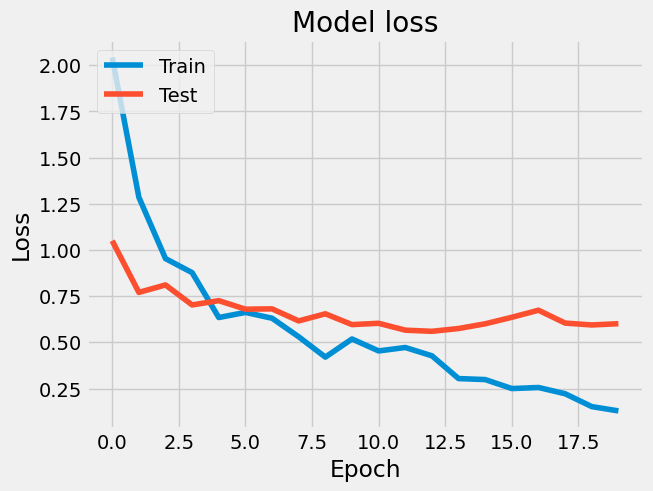

In [18]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
"""模型评估"""
print('val AUC: %f' % model.evaluate(valx_model_input, valy, batch_size=batch_size)[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - auc: 0.6131 - binary_crossentropy: 0.8900 - loss: 0.8900
val AUC: 0.613095
